# MNIST GAN with Autoencoder Pretraining

A Generative Adversarial Network contains two componenets, A generator and a discriminator. The generator's goal is to create new samples of the training data. The discriminator's goal is to point out the fakes (a binary clf). The two are trianed in an arms race. At each epoch of training, the discriminator is trained on a batch that contains a selection of real images as well as images that are created by the generator.   
.  
After the training of the discriminator has concluded, the generator then conducts training. The goal of the generator is to fool the discriminator into thinking that the images it creates are real. The generator is trained by plugging its own outputs into the discriminator and using the gradients of the discriminator's loss to inform itself how best to trick it.  
.  
In this project we will train a GAN to generate new MNIST digits. We will train an autoencoder on the MNIST fpr pretraining of the generator.  
.  
For context, an autoencoder is a neural network trained to reconstruct its input after compressing it. There are two compoennets, the encoder and the decoder. The encoder recieves input and compresses it by means of its hidden layers being smaller than the input layer. The decoder then takes the compressed representation and attempts to reconstruct the original input. Thus, the autoencoder must find the best compression algorithm as well as the best reconstruction algorithm. For this reason, autoencoders are often used for dimensionality reduction and denoising. The autoencoder is trained by minimizing the reconstruction loss, which is often Mean Squared Error or Binary Cross Entropy.   
.  
For our purposes, we will train an autoencoder on the MNIST. Once trained, we will seperate the decoder from the the encoder for use in our generator. The decoder will occupy the output layer, meaning that our generator will only need to construct the compressed representation. This significantly reduces the diffiuculty of training the generator.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LeakyReLU, GaussianNoise, Lambda
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt

Load MNIST

In [9]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Print the shapes of the loaded data
print("Training data shape:", x_train.shape)  # (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # (60000,)
print("Testing data shape:", x_test.shape)  # (10000, 28, 28)
print("Testing labels shape:", y_test.shape)  # (10000,)

x_train = x_train.astype(np.float32) / 255 #Normmalize the data to [0, 1]
x_test = x_test.astype(np.float32) / 255

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing data shape: (10000, 28, 28)
Testing labels shape: (10000,)


Here is a plot of MNIST Images.

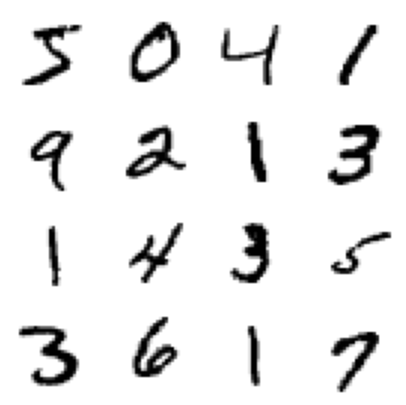

In [11]:
#plot MNIST images
plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='binary')
    plt.axis('off')
plt.show()

# Autoencoder Training

This Autoencoder is fairly simple. The encoder and decoder are defined as seperated sequential models which are then brought together into a single model before compilation.The encoder stacks dense layers that reduce in neurons as depth increases.  
.  
Dropout regularization works by randomly setting the weights of a percentage of neurons to zero during training. It does not apply after training has concluded. Dropout is used in the encoder to apply more pressure on individual neurons to learn useful features. After applying Dropout, blurrieness of the decoded images significatly reduced. 
.  
The decoder reverse the compression that has just taken place. It stacks dense layers that increase in neurons as depth increases. The decoder is trained to reconstruct the original input.  
.  
SELU activation is used on all layers except the output layer. SELU stands for Scaled Exponential Linear Unit. It is a version of ELU, Exponential Linear Unit, that will scale its layer outputs to have a mean of 0 and a standard deviation of 1. This is useful because it helps to prevent vanishing gradients.

(ELU itself is a version of RELU where the gradient will never be zero to prevent agianst dead neurons)

Sigmoid activation is used in the final layer because outputs of sigmoid activation are between 0 and 1 and this is the range of our input data.
.
Adam is used for optimization. Adam is a version of Stochastic Gradient Descent that uses momentum to speed up convergence. It is a good default optimizer.

In [12]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # 28*28=784 
    keras.layers.Dropout(0.15),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),

])

decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(300, activation="selu"),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                81530     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            269384    
                                                                 
Total params: 350,914
Trainable params: 350,914
Non-trainable params: 0
_________________________________________________________________


In [13]:
autoencoder.fit(x_train, x_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1331
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1078
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1042
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1022
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1006
Epoch 6/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0996
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0987
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0978
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0973
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0968
Epoch 11/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0964
Epoch 12/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0961
E

Let's plot mnist digits before and after they are fed into the autoencoder. 

1/1 [==============================] - 0s 18ms/step


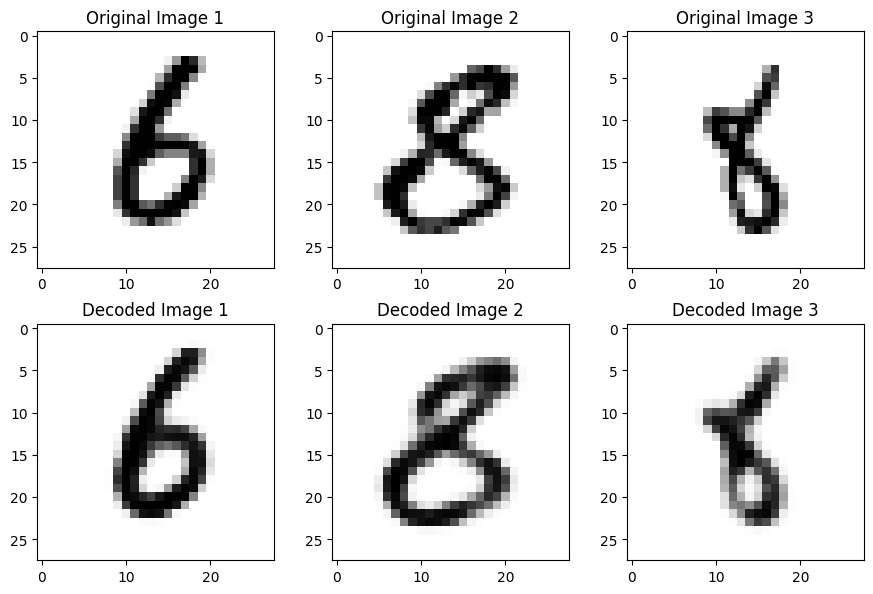

In [16]:
import matplotlib.pyplot as plt

example_nums = [3424, 1234, 5678]  # change these to any valid indices in your test set

fig, axs = plt.subplots(2, 3, figsize=(9, 6))  # create a subplot grid with 2 rows and 3 columns

for i, example_num in enumerate(example_nums):
    digit = np.expand_dims(x_test[example_num], axis=0) # include batch size for predict method
    decoded = autoencoder.predict(digit)
    decoded = np.squeeze(decoded, axis=0) # remove batch size for plt.imshow method

    axs[0, i].imshow(x_test[example_num], cmap="binary")
    axs[0, i].set_title("Original Image {}".format(i+1))

    axs[1, i].imshow(decoded, cmap="binary")
    axs[1, i].set_title("Decoded Image {}".format(i+1))

plt.tight_layout()
plt.show()


The decoded images are more noisy than the original. But not so much that they are unrecognizable. This will work for our purposes in the GAN.

Here we will seperate the Decoder for use in Generator (Transfer Learning). This will reduce the time and complexity of training the generator.

In [17]:
trained_decoder = autoencoder.layers[1] #extract decoder sequential model

We are going to train our intitial GAN to only generate zeros. Initially I had begun training with the entire dataset with all 10 digits. While successful in the sense that the GAN was able to produce realistic images, it was only able to generate one type of digit. This is a common issue with GAN training called mode collapse. It is where the discriminator picks up on a specific feature in the data which then informs the generator to make images of that sort, however the feature that was picked up is so specific that it reduces the models generalizability. Thus the output of the geenrator has collapsed into a single mode.

Here we separate the zeros from the larger set.

Zeroes Dataset Shape: (6903, 28, 28)


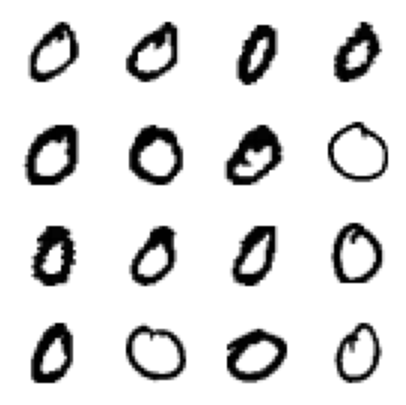

In [18]:
zeroes_dataset = sub_datasets[0]

print("Zeroes Dataset Shape:", zeroes_dataset.shape) 

#plot Zeroes images

plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(zeroes_dataset[i], cmap='binary')
    plt.axis('off')
plt.show()


# GAN Training

The code for structuring the trianing of the GAN was adapted for this project from this Kaggle page by Ishan Kotia: https://www.kaggle.com/discussions/general/247477

Here we define our generator. It is a simple feed forward network used for binary calssification. It takes as input a 28*28 mnist image and predicts whether it is real or fake. 

During training, a problem that I ran into frequently was that the discriminator was too good and it would leave the generator far behind in performance. And early into training at that. My solution to this was to worsen the discriminator by adding a very large amount of regularization in the form of dropout. Normally, dropout is used to improve a model. With an appropriate amount of dropout, individual neurons will better learn the dataset and rely less on their cohorts. However, in this case, we are using it to make the arms race between the generator and the discriminator a more fair match. 

After the flatten layer there is an 80 percent droptout rate, meaning that during the forward pass, 80 percent of the neuron weights will be set to zero. Meaning that the discriminator only recieves 20% of its input at any forward pass. In the suubsequent dense layer, there is 90% dropout. 

Aside from the heavy regualraization, the discriminator is a simple feed forward network. It is trained to predict whether an image is real or fake.


In [ ]:
def define_discriminator(in_shape=(28, 28)):
    #mnist discriminator

    discriminator = keras.models.Sequential([
        keras.layers.Flatten(input_shape=in_shape), #(28, 28) -> (784,)
        keras.layers.Dropout(0.80),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dropout(0.90),
        keras.layers.Dense(30, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid") #1 output neuron to predict whether image is real or fake
    ])

    discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"])

    return discriminator

discriminator = define_discriminator()

Below, the generator is defined. First, we randomly initalize the kernel and define the model input, which is a (10,) noise vector that must be generated whenever the model is called. The noise vector is then fed into a feed forward network that upsamples to 30 dimmensions. This 30d vector will then serve as the input of the decoder, which will create the ouput image. The training of the decoder has also been turned off, meaning that the only job of the generator is to create the optimal compressed mnist such that when fed to the decoder, it produces a digit. 

A common issue I ran into while trianing the generator was that the generator would create a realistic digit, however it would be the exact same digit every time. This is an example of mode collapes, where the generator gets stuck in a single mode of the data.   

Adding Gaussian noise has helped increase the diversity of the generated digits. But only in the way of varying line quality of the digit. This remains an issue with this model.

In [ ]:
def define_generator(): 
    
    init = keras.initializers.RandomNormal(stddev=0.02)
    in_latent = keras.layers.Input(shape=(10,))   #initial latent code

    #create latent code
    gen = Dense(10, kernel_initializer=init)(in_latent)
    gen = GaussianNoise(0.5)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Dense(20, kernel_initializer=init)(gen)
    gen = GaussianNoise(0.5)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Dense(20, kernel_initializer=init)(gen)
    gen = GaussianNoise(0.5)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
 
    gen = Dense(25, kernel_initializer=init)(gen)
    gen = GaussianNoise(0.2)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Dense(30, kernel_initializer=init)(gen)
    gen = GaussianNoise(0.2)(gen)
    latent_code = LeakyReLU(alpha=0.2)(gen)  

    # feed decoder mnist decoder generated latent code
    output = trained_decoder(latent_code)

    model = keras.Model(in_latent, output)

    return model

trained_decoder.trainable = False
generator = define_generator()

Here we define and compile the model which will train the geenrator component we outlined above. 

The key to understanding how training of the generator works is that we have turned off the training of the discriminator. By using the prediction of the discriminator to train the generator, we can reduce the loss of the discriminator by improving the quality of the generated images by using binary cross entropy. Keep in mind, though, that although the loss of the discriminator reduces, it does not mean the discriminator has gotten better. It just means the generator has learned to better fooled the discriminator. In other words, the images have become more realistic. 

In [ ]:
def define_gan(g_model, d_model):
    '''
    This function defines the combined GAN model, which takes a point in the latent space as input and outputs the 
    discriminator's prediction on whether the image generated from this point by the generator is real or fake.
    '''
    d_model.trainable = False #turn off discriminator training
    gan_output = d_model(g_model.output) # connect the image output from generator as input to discriminator
    model = keras.Model(g_model.input, gan_output)  #define entire model by chaining together generator and discriminator

    opt = Adam(lr=0.001, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
    
    return model

gan_model = define_gan(generator, discriminator)

Below are necessary functions for a training epoch.

In [22]:
def generate_real_samples(X_train, n_samples):
    '''
    This function randomly selects images from the 
    dataset and associates them with a label of 1 
    (indicating that they are real images).
    '''
    real_selection = np.random.randint(0, X_train.shape[0], n_samples) #generate random integers from 0 to the number of images in the dataset. ie: select random indices from the dataset
    X = X_train[real_selection]   #select the images with the randomly selected indices for the current epoch
    y = np.ones((n_samples, 1)) #label randomly selected real images from the dataset as 1
    return X, y

def generate_noise(n_samples, noise_dim=10):
    '''
    This function generates a batch of noise vectors to use as input for the generator.
    '''
    noise = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return noise

def generate_fake_samples(generator, n_samples, noise_dim=10):
    '''
    This function generates fake images and 
    associates them with a label of 0 
    (indicating that they are fake images).
    '''
    noise = generate_noise(n_samples, noise_dim)
    images = generator.predict(noise)
    y = np.zeros((n_samples, 1))
    return images, y

Inside the function train function, there is an early stopping feature. This was used instead of a keras callback because of the unique way the generator is trained. ie with regular interuptions. 

A training cycle includes training the discriminator on real, then on fake, then training the generator.

In [ ]:
def train(g_model, d_model, gan_model, X_train, n_epochs=10, n_batch=64, save_path=None):

    #initialize early stopping parameters
    best_loss = np.inf # initiliaze loss to large val as placeholder
    patience = 500
    patience_counter = 0

    #training cycle
    for i in range(n_epochs):
        
        X_real, y_real = generate_real_samples(X_train, n_batch) #select real images 
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real) #train discriminator on real images

        X_fake, y_fake = generate_fake_samples(g_model, n_batch) #generate fake images
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake) #train discriminator on fake images

        noise = generate_noise(n_batch)
        y_gan = np.ones((n_batch, 1))
        g_loss, g_acc = gan_model.train_on_batch(noise, y_gan) #train GAN on fake images

        print('>%d, D loss and accuracy on real: [%.3f,%.3f], D loss and accuracy on fake: [%.3f,%.3f], G loss and accuracy: [%.3f,%.3f]' % (i+1, d_loss_r,d_acc_r, d_loss_f,d_acc_f, g_loss,g_acc))

        #Manual Early Stopping Check
        if g_loss < best_loss:  #if g_loss is better that previous best loss, reset patience counter
            best_loss = g_loss
            patience_counter = 0 
        else:
            patience_counter += 1 #if g_loss is not better than previous best loss, increment patience counter

        #Stop training if patience has expired
        if patience_counter >= patience:
            print(f'Early stopping due to no improvement after {patience} steps.')
            break

train(generator, discriminator, gan_model, zeroes_dataset, n_epochs=1000, n_batch=10)

1/1 [==============================] - 0s 13ms/step


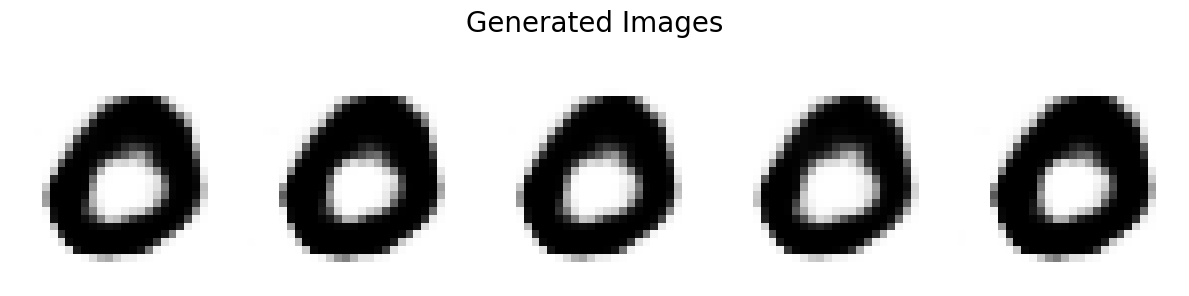

In [24]:
#Create fig with 5 generated images
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle("Generated Images", fontsize=20)
for i in range(5):
    noise = generate_noise(1)
    generated_image = generator.predict(noise)
    axes[i].imshow(generated_image.reshape(28, 28), cmap="binary")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

The generated zeroes are all realistic mnist images. However, they are all the exact same image. This is an example of mode collapse. I intend to improve on this issue in a future revision.

Let's now train 10 GANs, one for each digit. This is a get around for single digit mode collapse issues when training one gan on all digits at once. 

We will use np.where to filter the dataset into ten subdatasets, one for each image. 

In [25]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255 #Normmalize the data to [0, 1]
x_test = x_test.astype(np.float32) / 255

concatenated_examples = np.concatenate((x_train, x_test))
concatenated_labels = np.concatenate((y_train, y_test))

# Create a dictionary to store each digit's data
sub_datasets = {}

# Loop through digits 0-9
for i in range(10):
    # Find indices where the label is the digit
    digit_indices = np.where(concatenated_labels == i)
    # Use these indices to find the associated images
    sub_datasets[i] = concatenated_examples[digit_indices]

for key in sub_datasets.keys():
    print(f"Digit {key}: {sub_datasets[key].shape}")


Digit 0: (6903, 28, 28)
Digit 1: (7877, 28, 28)
Digit 2: (6990, 28, 28)
Digit 3: (7141, 28, 28)
Digit 4: (6824, 28, 28)
Digit 5: (6313, 28, 28)
Digit 6: (6876, 28, 28)
Digit 7: (7293, 28, 28)
Digit 8: (6825, 28, 28)
Digit 9: (6958, 28, 28)


Here we call the train function for each of our sub datasets and store the generators in the digit_generators list

In [ ]:
digit_generators = [] #list to store generators for each digit

for i in range(10):
    digit_set = sub_datasets[i]  #get digit dataset that matches current iteration

    #redefine generator, discriminator, and GAN for new digit dataset training
    generator = define_generator()
    discriminator = define_discriminator()
    gan_model = define_gan(generator, discriminator)

    train(generator, discriminator, gan_model, digit_set, n_epochs=1000, n_batch=10) #train GAN on current digit dataset

    digit_generators.append(generator) #append generator for current digit to list of generators

Let's now plot one of each generated image

1/1 [==============================] - 0s 17ms/step


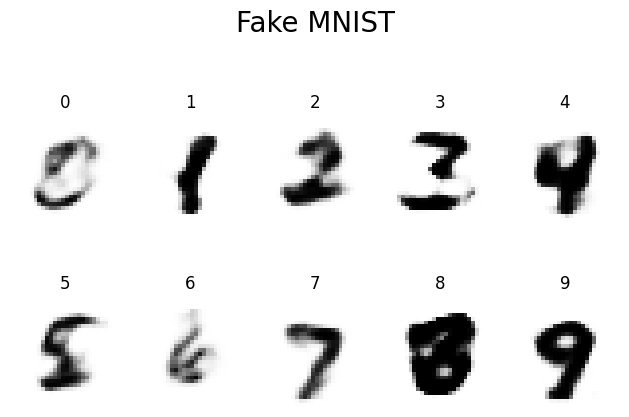

In [31]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(digit_generators[i].predict(generate_noise(1)).reshape(28, 28), cmap="binary")
    plt.axis("off")

#set title for entire figure
plt.suptitle("Fake MNIST", fontsize=20)

plt.tight_layout()
plt.show()

There is still a fair bit of noise and the individual digt generators suffer from mode collapse issues still. These will be adressed in an update on this project.

Hoever the quality of the images are all recognizable as the class they belong to, maybe excluding the 6 if not in the context of the others. 